# COMP4318/5318 Assignment 2: Image Classification

### Group number: 77, SID1: 540969766, SID2: 540798188, SID3:  , SID4: 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [46]:
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# FCNN and CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [47]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [48]:
# Check the shape of the dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


### Preprocessing

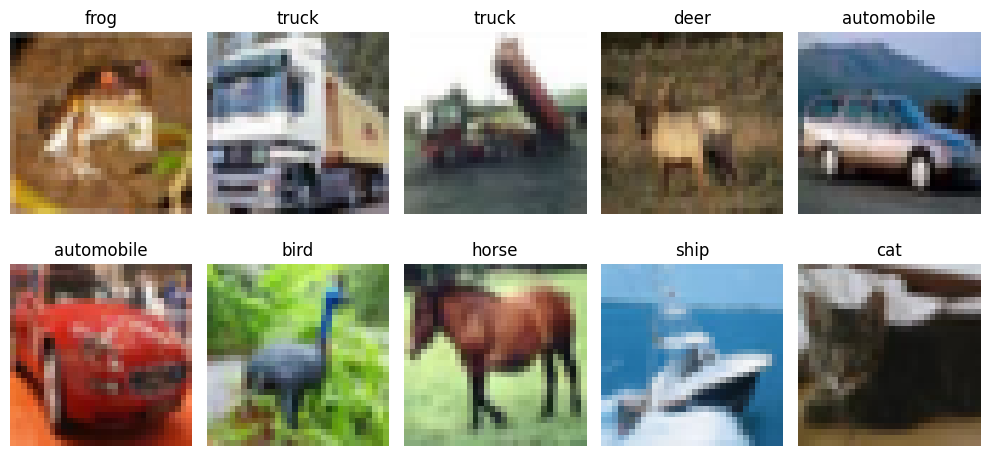

In [49]:
# Plot some examples of the dataset with labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    # Handle both (50000, 1) and (50000,) cases
    label_index = y_train[i] if np.ndim(y_train) == 1 else y_train[i][0]
    plt.title(class_names[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [50]:
# Check the model's performance with subset of the whole dataset

# Flatten the labels for classical models
y_train = y_train.flatten()
y_test = y_test.flatten()

label_counts = pd.Series(y_train).value_counts().sort_index()
print(f"Label counts: {label_counts}\n\n")

# Normalize pixel values for all models 
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# One-hot encode labels for Neural Networks 
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Flatten images for classical models
X_train_flat = X_train_norm.reshape((X_train.shape[0], -1))
X_test_flat = X_test_norm.reshape((X_test.shape[0], -1))

# Subsample for classical models to prevent overload
X_small, _, y_small, _ = train_test_split(
    X_train_flat, y_train, train_size=2000, stratify=y_train, random_state=42
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_flat, y_test, train_size=400, stratify=y_test, random_state=42
)
# Normalize images for neural networks
X_small_norm = X_small.astype("float32") / 255.0
X_test_small_norm = X_test_small.astype("float32") / 255.0

X_small_norm = X_train_norm[:2000]
y_small_cat = y_train_cat[:2000]
X_test_small_norm = X_test_norm[:400]
y_test_small_cat = y_test_cat[:400]

print("Reduced classical training shape:", X_small.shape)
print("Reduced classical test shape:", X_test_small.shape)

Label counts: 0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64




KeyboardInterrupt: 

In [ ]:
X_small_norm.shape

In [ ]:
# Data Augmentation to introduce more variation in the training data
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

In [ ]:
# Based on https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly choose 10 samples
indices = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[y_train[idx]])
    plt.axis('off')
plt.suptitle("Examples of Preprocessed CIFAR-10 Images", fontsize=14)
plt.tight_layout()
plt.show()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [ ]:
class ClassificationModel:

    def logistic_regression(self):
        log_reg = LogisticRegression(random_state=42) 
        hyperparameter = {"model__C": [0.1, 1.0], "model__max_iter": [500, 1000]}
        return log_reg, hyperparameter
    def svm(self):
        svm = SVC(random_state=42)
        hyperparameter = {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]}
        return svm, hyperparameter
    def decision_tree(self):
        dt = DecisionTreeClassifier(random_state=42)
        hyperparameter = {"model__max_depth": [5, 10, 20, None], "model__min_samples_split": [2, 5, 10]}
        return dt, hyperparameter
    
    def random_forest(self, n_estimators = None, max_depth = None, min_samples_leaf = None, bootstrap = True):
        rf = RandomForestClassifier(random_state=42)
        hyperparameter = {"model__n_estimators":[50, 100, 200] if n_estimators == None else n_estimators,
                           "model__max_depth": [5, 10, 20, 30] if max_depth == None else max_depth,
                           "model__min_samples_leaf": [2, 5, 10] if min_samples_leaf == None else min_samples_leaf}
                        #    "model__bootstrap": [True] if bootstrap == True else [True, False]}
        return rf, hyperparameter
    
    def ada_boost(self):
        adb = AdaBoostClassifier(random_state=42, algorithm='SAMME')
        hyperparameter = {"model__n_estimators": [50, 100], "model__learning_rate": [0.01, 0.1]}
        return adb, hyperparameter
    
    def gradient_boost(self):
        gb = GradientBoostingClassifier(random_state=42)
        hyperparameter = {
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [1, 3]
        }
        return gb, hyperparameter
    
    def bagging(self):
        bag = BaggingClassifier()
        hyperparameter = {"model__n_estimators": [50, 100]}
        return bag, hyperparameter
    
    def naivebayes(self):
        nb = GaussianNB()
        hyperparameter = {}
        return nb, hyperparameter
    
    def cnn(self, filters1=32, filters2=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, **kwargs):
        model = Sequential([
            Conv2D(filters1, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(32,32,3)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2)),

            Conv2D(filters2, (kernel_size, kernel_size), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2)),

            Flatten(),
            Dense(128, activation='relu'),
            Dropout(dropout_rate),
            Dense(10, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def mlp(self, hidden_units=512, dropout_rate=0.3, learning_rate=0.001):
        model = Sequential([
            Flatten(input_shape=(32, 32, 3)),
            Dense(hidden_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(hidden_units // 2, activation='relu'),
            Dropout(dropout_rate / 2),
            Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
        
    def run_model(self, model,
               X_train, y_train,
               X_test, y_test,
               use_pca=False, n_components=0.95,
               verbose=1):
        """
        Train and evaluate a single model (optionally with PCA), without hyperparameter tuning.

        Args:
            model: sklearn estimator
            X_train, y_train: training data
            X_test, y_test: testing data
            use_pca (bool): whether to apply PCA
            n_components (float or int): PCA components (variance or count)
            verbose (int): verbosity level

        Returns:
            best_model: trained pipeline
            test_acc: test accuracy
        """

        # --- Ensure labels are integers ---
        y_train_int = y_train.argmax(axis=1) if y_train.ndim > 1 and y_train.shape[1] > 1 else y_train
        y_test_int  = y_test.argmax(axis=1)  if y_test.ndim > 1 and y_test.shape[1] > 1 else y_test

        # --- Build pipeline ---
        steps = []
        if use_pca:
            steps.append(("reduce", PCA(n_components=n_components)))
        steps.append(("model", model))
        pipe = Pipeline(steps)

        # --- Train ---
        pipe.fit(X_train, y_train_int)

        # --- Predict ---
        y_pred_labels = pipe.predict(X_test)

        # --- Metrics ---
        accuracy_val = accuracy_score(y_test_int, y_pred_labels)
        f1_val       = f1_score(y_test_int, y_pred_labels, average='macro')

        if verbose:
            print(f"Model trained. Accuracy = {accuracy_val:.4f}, F1-score = {f1_val:.4f}")

        return pipe, accuracy_val, f1_val
    
    def tune_model(self, model, param_grid,
               X_train, y_train,
               X_test, y_test,
               use_pca=False, n_components=0.95,
               cv_folds=10, verbose=1):
        """
        Train/tune a single model (optionally with PCA) using GridSearchCV.

        Args:
            model: sklearn estimator
            param_grid (dict): grid for GridSearchCV (can be empty for no tuning)
            X_train, y_train: training data
            X_test, y_test: testing data
            use_pca (bool): whether to apply PCA
            n_components (float or int): PCA components (variance or count)
            cv_folds (int): number of CV folds
            verbose (int): verbosity level

        Returns:
            best_model: trained pipeline (best estimator)
            test_acc: test accuracy
        """

        # --- Step 1: Build pipeline ---
        steps = []
        if use_pca:
            steps.append(("reduce", PCA(n_components=n_components)))
        steps.append(("model", model))
        pipe = Pipeline(steps)

        # --- Step 2: Check if tuning is needed ---
        if not param_grid:
            pipe.fit(X_train, y_train)
            acc = accuracy_score(y_test, pipe.predict(X_test))
            print(f"Model trained without tuning. Test Accuracy = {acc:.4f}")
            return pipe, acc

        # --- Step 3: GridSearchCV ---
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv_folds,
            n_jobs=-1,
            scoring="accuracy",
            verbose=verbose
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        # --- Step 4: Evaluate ---
        test_acc = accuracy_score(y_test, best_model.predict(X_test))
        print(f"Best Params = {search.best_params_}, Test Accuracy = {test_acc:.4f}")

        return best_model, test_acc

        
classification_model = ClassificationModel()



### Fully connected neural network

In [ ]:

mlp_base = KerasClassifier(
    model=classification_model.mlp(),
    epochs=50,
    batch_size=64,
    verbose=1
)

# --- Train (using small normalized dataset) ---
mlp_base.fit(X_small_norm, y_small_cat, validation_data=(X_test_small_norm, y_test_small_cat))

# Predict on small test set
y_pred = mlp_base.predict(X_test_small_norm)

# Convert one-hot true labels to integer
y_true = y_test_small_cat.argmax(axis=1)

# If predictions are probabilities, convert to class index
if y_pred.ndim > 1:
    y_pred = y_pred.argmax(axis=1)

# Compute metrics
mlp_acc = accuracy_score(y_true, y_pred)
mlp_f1 = f1_score(y_true, y_pred, average='macro')  # use y_true, not y_test
print(f"✅ Test Accuracy: {mlp_acc:.4f}, F1-score: {mlp_f1:.4f}")


### Convolutional neural network

In [ ]:
cnn = classification_model.cnn()

cnn_base = KerasClassifier(
    model=cnn,
    epochs=20,
    batch_size=64,
    verbose=1
)
# Compile CNN
cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

cnn.summary()


In [ ]:
cnn_base = KerasClassifier(
    model=cnn,
    epochs=50,
    batch_size=64,
    verbose=1
)
cnn_base.fit(
    X_small_norm, y_small_cat,
    validation_data=(X_test_small_norm, y_test_small_cat)
)

# Predict on small test set
y_pred = cnn_base.predict(X_test_small_norm)

# Convert one-hot true labels to integers
y_true = y_test_small_cat.argmax(axis=1)

# If predictions are probabilities, convert to class index
if y_pred.ndim > 1:
    y_pred = y_pred.argmax(axis=1)

# Compute metrics
cnn_acc = accuracy_score(y_true, y_pred)
cnn_f1 = f1_score(y_true, y_pred, average='macro')  # use y_true, not y_test
print(f"✅ CNN Base Test Accuracy: {cnn_acc:.4f}, F1-score: {cnn_f1:.4f}")

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(cnn_base.history_['loss'], label='Loss')
plt.plot(cnn_base.history_['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(cnn_base.history_['accuracy'], label='accuracy')
plt.plot(cnn_base.history_['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(cnn_base.history_['precision'], label='precision')
plt.plot(cnn_base.history_['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(cnn_base.history_['recall'], label='recall')
plt.plot(cnn_base.history_['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
y_pred = cnn.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)

# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
# Define base models
models = {
    "Logistic Regression": classification_model.logistic_regression()[0],
    "SVM": classification_model.svm()[0],
    "Decision Tree": classification_model.decision_tree()[0],
    "Random Forest": classification_model.random_forest()[0],
    "AdaBoost": classification_model.ada_boost()[0],
    "Gradient Boosting": classification_model.gradient_boost()[0],
    "Bagging": classification_model.bagging()[0],
    "Naive Bayes": classification_model.naivebayes()[0]
}

use_pca_flags = {
    "Logistic Regression": False,
    "SVM": False,
    "Decision Tree": False,
    "Random Forest": False,
    "AdaBoost": False,
    "Gradient Boosting": True,
    "Bagging": False,
    "Naive Bayes": False
}

tuned_results = {}
best_models = {}

for name, model in models.items():
    print(f"\n Training {name}...")
    use_pca = use_pca_flags.get(name, False)
    
    pipe, test_acc, test_f1 = classification_model.run_model(
        model=model,
        X_train=X_small,
        y_train=y_small,
        X_test=X_test_small,
        y_test=y_test_small,
        use_pca=use_pca,
        n_components=0.95
    )

    tuned_results[name] = {"accuracy": test_acc, "f1_score": test_f1}

    

print(f"\nOverall performance of the models: {tuned_results}")

In [ ]:
tuned_results['CNN'] = {"accuracy": cnn_acc, "f1_score": cnn_f1}
tuned_results['MLP'] = {"accuracy": mlp_acc, "f1_score": mlp_f1}
# Convert dictionary to DataFrame
results_df = pd.DataFrame.from_dict(tuned_results, orient='index')  
results_df.index.name = 'Model'
results_df.reset_index(inplace=True)

print("\nModel Performance Summary:")
print(results_df)

## 3. Hyperparameter tuning

In [ ]:
# Helper functions for plotting
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### CNN

In [ ]:
predictions = cnn.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

### Algorithm of choice from first six weeks of course
- Random Forest
- SVM

In [ ]:
# X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
#     X_train_flat, y_train, test_size=0.2, random_state=42
# )


model_rf = classification_model.random_forest(bootstrap=False)

# Hyperparameter tuning for Random Forest
rf  = classification_model.tune_model(model = model_rf[0], param_grid=model_rf[1], cv_folds=10, X_train = X_train_flat, y_train = y_train, X_test = X_test_flat, y_test=y_test, use_pca = False)


print(f"Accuracy: {rf[1]}, Best Parameters: {rf[0]}")
# # --- Train on a subset for speed (optional) ---
# rf.fit(X_train_rf, y_train_rf)

# # --- Predict on validation set ---
# y_pred_val = rf.predict(X_val_rf)  # smaller batch for quick test

# # --- Evaluate accuracy ---
# acc = accuracy_score(y_val_rf, y_pred_val)
# print(f"Validation Accuracy: {acc:.4f}")

In [ ]:

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
batch_size = 64

train_gen = data_generator.flow(
    X_small_norm, y_small_cat,
    batch_size=batch_size
)
param_grid_cnn = {
    "filters1": [32, 64],
    "filters2": [64, 128],
    "kernel_size": [3, 5],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [15, 30]
}

keys, values = zip(*param_grid_cnn.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_acc = 0
best_params = None
best_model = None

for params in combinations:
    print("Testing params:", params)
    
    model = classification_model.cnn(
        filters1=params['filters1'],
        filters2=params['filters2'],
        kernel_size=params['kernel_size'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    # Create generator for this batch size
    train_gen = data_generator.flow(
        X_small_norm, y_small_cat,
        batch_size=params['batch_size']
    )
    
    model.fit(
        train_gen,
        steps_per_epoch=len(X_small_norm) // params['batch_size'],
        validation_data=(X_test_small_norm, y_test_small_cat),
        epochs=params['epochs'],
        verbose=0
    )
    
    y_pred = model.predict(X_test_small_norm).argmax(axis=1)
    y_true = y_test_small_cat.argmax(axis=1)
    acc = accuracy_score(y_true, y_pred)
    
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_params = params
        print(f"🎯 New best accuracy: {best_acc:.4f}")

print("Best CNN params:", best_params)


Testing params: {'filters1': 32, 'filters2': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15}
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
🎯 New best accuracy: 0.3875
Testing params: {'filters1': 32, 'filters2': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at le

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
🎯 New best accuracy: 0.3900
Testing params: {'filters1': 32, 'filters2': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 15}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [ ]:
param_grid_mlp = {
    "hidden_units": [256, 512],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [15, 30]
}

keys, values = zip(*param_grid_mlp.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_acc = 0
best_model = None
best_params = None

for params in combinations:
    print("Testing params:", params)
    
    model = classification_model.mlp(
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    history = model.fit(
        X_small_norm, y_small_cat,
        validation_data=(X_test_small_norm, y_test_small_cat),
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=0
    )
    
    y_pred = model.predict(X_test_small_norm).argmax(axis=1)
    y_true = y_test_small_cat.argmax(axis=1)
    
    acc = accuracy_score(y_true, y_pred)
    if acc > best_acc:
        best_acc_mlp = acc
        best_model = model
        best_params_mlp = params
        print(f"🎯 New best accuracy: {best_acc_mlp:.4f}")

print("Best MLP params:", best_params_mlp)

Testing params: {'hidden_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.2925
Testing params: {'hidden_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.3425
Testing params: {'hidden_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 15}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.2800
Testing params: {'hidden_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 30}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.3050
Testing params: {'hidden_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 15}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.3150
Testing params: {'hidden_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32, 'epochs': 30}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.3400
Testing params: {'hidden_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 15}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.3350
Testing params: {'hidden_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 30}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.3525
Testing params: {'hidden_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.2525
Testing params: {'hidden_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.3025
Testing params: {'hidden_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 15}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🎯 New best accuracy: 0.3050
Testing params: {'hidden_units': 256, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 30}


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(12, 16))

# plt.subplot(4, 2, 1)
# plt.plot(r.history['loss'], label='Loss')
# plt.plot(r.history['val_loss'], label='val_Loss')
# plt.title('Loss Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 2)
# plt.plot(r.history['accuracy'], label='accuracy')
# plt.plot(r.history['val_accuracy'], label='val_accuracy')
# plt.title('Accuracy Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 3)
# plt.plot(r.history['precision'], label='precision')
# plt.plot(r.history['val_precision'], label='val_precision')
# plt.title('Precision Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 4)
# plt.plot(r.history['recall'], label='recall')
# plt.plot(r.history['val_recall'], label='val_recall')
# plt.title('Recall Function Evolution')
# plt.legend()

### Fully connected neural network

### Convolutional neural network

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network